In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from kdelearn.kde_tasks import KDEOutliersDetection
from kdelearn.metrics import pi_kf
from kdelearn.kde import KDE
from kdelearn.bandwidth_selection import direct_plugin
from sklearn.neighbors import NearestNeighbors

In [53]:
# !ls ../../data/annthyroid/

In [54]:
data = pd.read_csv("/home/krystian/Downloads/archive/thyroidDF.csv")

In [55]:
data.shape

(9172, 31)

In [56]:
data = data[data["target"].isin(["-", "G", "F"])]
data.loc[data["target"]=="-", "target"] = 0
data.loc[data["target"]=="G", "target"] = 1
data.loc[data["target"]=="F", "target"] = 2
data["target"] = data["target"].astype(int)
data = data.reset_index(drop=True)

data.shape

(7363, 31)

In [57]:
data = data[["TSH", "target"]].dropna()
data.shape

(6674, 2)

In [58]:
data["target"].value_counts()

0    6082
1     359
2     233
Name: target, dtype: int64

# TSH

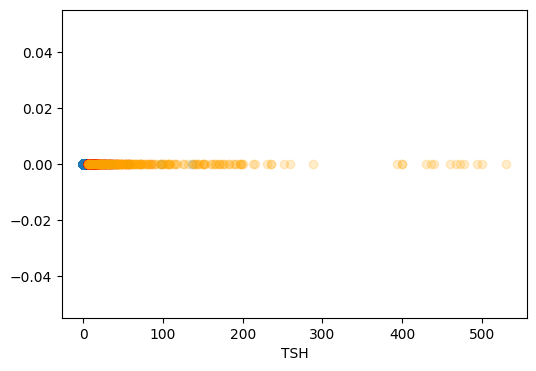

In [59]:
plt.figure(figsize=(6 ,4))
plt.scatter(data.loc[data["target"] == 0, "TSH"], data.loc[data["target"] == 0, "TSH"]*0, alpha=0.2)
plt.scatter(data.loc[data["target"] == 1, "TSH"], data.loc[data["target"] == 1, "TSH"]*0, c="red", alpha=0.2)
plt.scatter(data.loc[data["target"] == 2, "TSH"], data.loc[data["target"] == 2, "TSH"]*0, c="orange", alpha=0.2)
plt.xlabel("TSH")
plt.show()

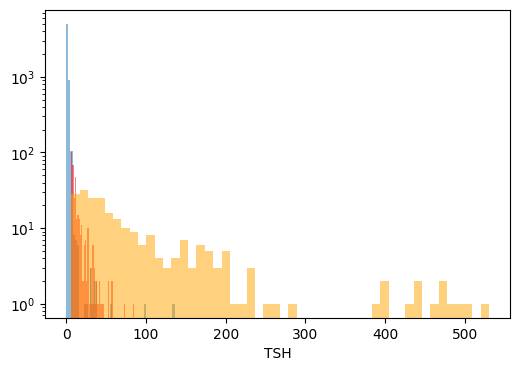

In [32]:
plt.figure(figsize=(6, 4))
plt.hist(data.loc[data["target"] == 0, "TSH"], bins=50, alpha=0.5)
plt.hist(data.loc[data["target"] == 1, "TSH"], bins=50, alpha=0.5, color="red")
plt.hist(data.loc[data["target"] == 2, "TSH"], bins=50, alpha=0.5, color="orange")
plt.yscale("log")
plt.xlabel("TSH")
plt.show()

In [33]:
data_tmp = data[["TSH", "target"]].copy()

x_train = data_tmp[["TSH"]].to_numpy().copy()
labels_train = data_tmp["target"].to_numpy().copy()
labels_train[labels_train!=0] = 1

\newpage

# Outliers detection - kde

## Siatka po r

In [152]:
bandwidth = direct_plugin(x_train)

In [164]:
metrics_list = []
r_list = []
for r in np.arange(0.01, 0.51, 0.01):
    r = round(r, 3)
    outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth, r=r)
    labels_pred = outliers_detector.predict(x_train)
    
    metric = pi_kf(x_train, labels_pred, bandwidth=bandwidth)
    metrics_list.append(metric)
    r_list.append(r)

idx = np.argmin(metrics_list)
print(f"Najlepsze r: {r_list[idx]:.3f}, Wskaźnik: {metrics_list[idx]:.3f}\n")

res = confusion_matrix(labels_train, labels_pred)
print(res)
print(f"precision: {res[1, 1] / res[:, 1].sum()}")
print(f"recall: {res[1, 1] / res[1, :].sum()}")
print(f"accuracy: {np.diag(res).sum() / res.sum()}")

Najlepsze r: 0.050, Wskaźnik: 0.445

[[3249 2833]
 [   0  592]]
precision: 0.17284671532846715
recall: 1.0
accuracy: 0.575516931375487


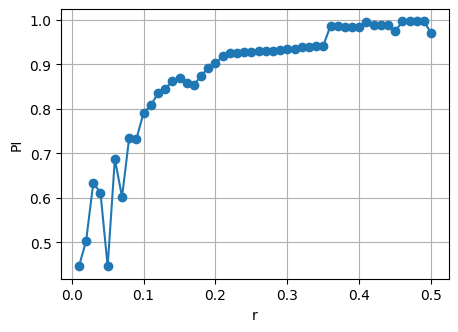

In [165]:
plt.figure(figsize=(5, 3.5))
plt.plot(r_list, metrics_list, "-o")
plt.xlabel("r")
plt.ylabel("PI")
plt.grid()
plt.show()

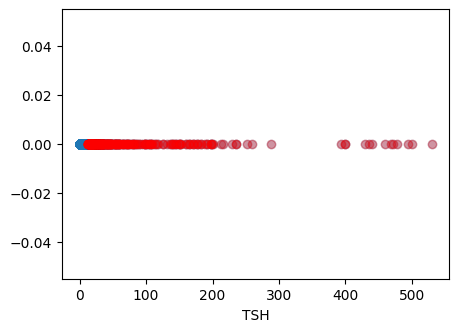

In [166]:
plt.figure(figsize=(5, 3.5))

outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth, r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)
plt.scatter(x_train[:, 0], x_train[:, 0]*0, alpha=0.3)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0]*0, alpha=0.3, c="red")

plt.xlabel("TSH")
plt.show()

Logarytm przy zmiennej x (TSH)

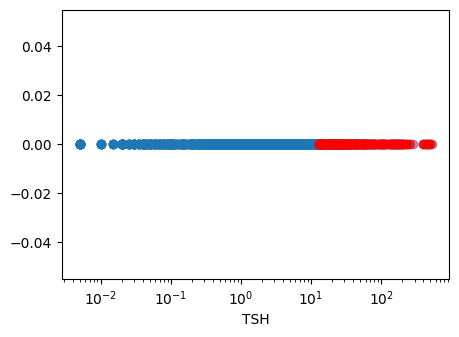

In [167]:
plt.figure(figsize=(5, 3.5))

plt.scatter(x_train[:, 0], x_train[:, 0]*0, alpha=0.3)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0]*0, alpha=0.3, c="red")

plt.xscale("log")
plt.xlabel("TSH")
plt.show()

\newpage

## Siatka po mnożniku h (przy r=0.0887)

In [168]:
metrics_list = []
h_mul_list = []
for h_mul in np.arange(0.2, 10.2, 0.2):
    outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * h_mul, r=0.0887)
    labels_pred = outliers_detector.predict(x_train)
    
    metric = pi_kf(x_train, labels_pred, bandwidth=bandwidth * h_mul)
    metrics_list.append(metric)
    h_mul_list.append(h_mul)

idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, Wskaźnik: {metrics_list[idx]:.3f}\n")

res = confusion_matrix(labels_train, labels_pred)
print(res)
print(f"precision: {res[1, 1] / res[:, 1].sum()}")
print(f"recall: {res[1, 1] / res[1, :].sum()}")
print(f"accuracy: {np.diag(res).sum() / res.sum()}")

Najlepszy mnożnik h: 4.000, Wskaźnik: 0.679

[[6033   49]
 [  40  552]]
precision: 0.9184692179700499
recall: 0.9324324324324325
accuracy: 0.9866646688642493


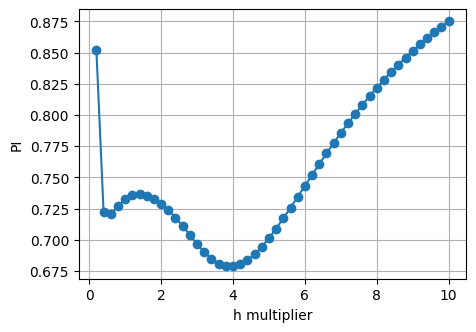

In [169]:
plt.figure(figsize=(5, 3.5))
plt.plot(h_mul_list, metrics_list, "-o")
plt.xlabel("h multiplier")
plt.ylabel("PI")
plt.grid()
plt.show()

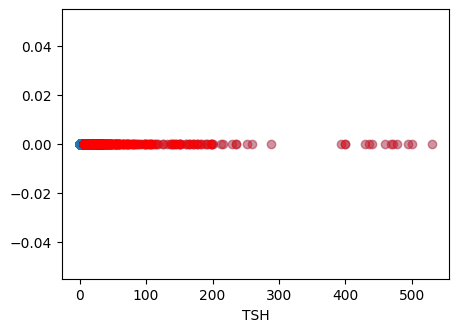

In [170]:
plt.figure(figsize=(5, 3.5))

outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * h_mul_list[idx], r=0.0887)
labels_pred = outliers_detector.predict(x_train)
plt.scatter(x_train[:, 0], x_train[:, 0]*0, alpha=0.3)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0]*0, alpha=0.3, c="red")

plt.xlabel("TSH")
plt.show()

Logarytm przy zmiennej x (TSH)

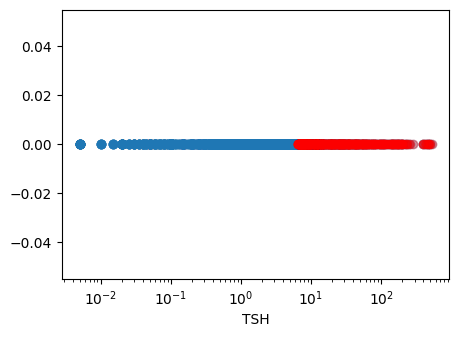

In [171]:
plt.figure(figsize=(5, 3.5))

plt.scatter(x_train[:, 0], x_train[:, 0]*0, alpha=0.3)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0]*0, alpha=0.3, c="red")

plt.xscale("log")
plt.xlabel("TSH")
plt.show()

\newpage

## Siatka po r i mnozniku h

In [172]:
metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.2, 10.2, 0.2):
    for r in np.arange(0.01, 0.51, 0.01):
        r = round(r, 3)
        outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * h_mul, r=r)
        labels_pred = outliers_detector.predict(x_train)

        metric = pi_kf(x_train, labels_pred, bandwidth=bandwidth * h_mul)
        metrics_list.append(metric)
        h_mul_list.append(h_mul)
        r_list.append(r)

idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]:.3f}, Wskaźnik: {metrics_list[idx]:.3f}\n")

res = confusion_matrix(labels_train, labels_pred)
print(res)
print(f"precision: {res[1, 1] / res[:, 1].sum()}")
print(f"recall: {res[1, 1] / res[1, :].sum()}")
print(f"accuracy: {np.diag(res).sum() / res.sum()}")

Najlepszy mnożnik h: 10.000, r: 0.040, Wskaźnik: 0.264

[[3267 2815]
 [   0  592]]
precision: 0.17375990607572644
recall: 1.0
accuracy: 0.5782139646388972


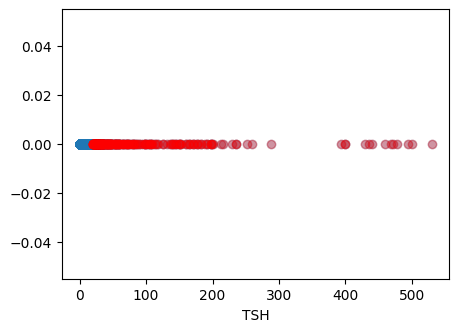

In [173]:
plt.figure(figsize=(5, 3.5))

outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)
plt.scatter(x_train[:, 0], x_train[:, 0]*0, alpha=0.3)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0]*0, alpha=0.3, c="red")

plt.xlabel("TSH")
plt.show()

Logarytm przy zmiennej x (TSH)

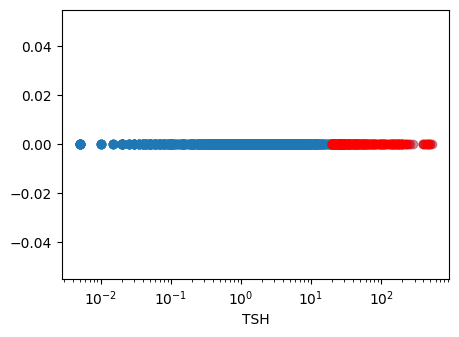

In [174]:
plt.figure(figsize=(5, 3.5))

plt.scatter(x_train[:, 0], x_train[:, 0]*0, alpha=0.3)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0]*0, alpha=0.3, c="red")

plt.xscale("log")
plt.xlabel("TSH")
plt.show()

\newpage

# Outliers detection - knn

## Siatka po r (przy k=10)

In [102]:
metrics_list = []
r_list = []
for r in np.arange(0.01, 0.11, 0.01):
    r = round(r, 3)
    nbrs = NearestNeighbors(n_neighbors=11, algorithm='brute').fit(x_train)
    distances, indices = nbrs.kneighbors(x_train)
    dist_k = np.max(distances, axis=1)
    threshold = np.quantile(dist_k, 1 - r)
    labels_pred = np.where(dist_k >= threshold, 1, 0)
    
    inliers = labels_pred == 0
    outliers = labels_pred == 1
    n_outliers = (outliers == 1).sum()
    n_inliers = (outliers == 0).sum()
    tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
    dist_out = np.sort(dist_k[outliers])[:tmp]
    dist_in = np.sort(dist_k[inliers])[-tmp:]
    metric = dist_in.sum() / dist_out.sum()
    
    metrics_list.append(metric)
    r_list.append(r)

idx = np.argmin(metrics_list)
print(f"Najlepsze r: {r_list[idx]:.3f}, Wskaźnik: {metrics_list[idx]:.3f}\n")

res = confusion_matrix(labels_train, labels_pred)
print(res)
print(f"precision: {res[1, 1] / res[:, 1].sum()}")
print(f"recall: {res[1, 1] / res[1, :].sum()}")
print(f"accuracy: {np.diag(res).sum() / res.sum()}")

Najlepsze r: 0.080, Wskaźnik: 0.126

[[5726  356]
 [ 125  467]]
precision: 0.5674362089914945
recall: 0.7888513513513513
accuracy: 0.9279292777944261


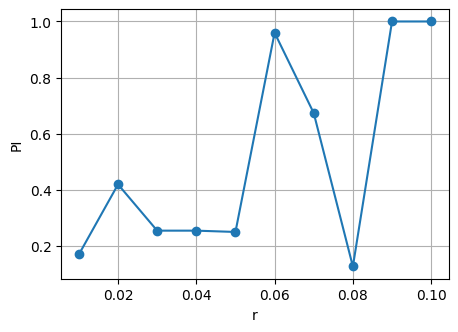

In [103]:
plt.figure(figsize=(5, 3.5))
plt.plot(r_list, metrics_list, "-o")
plt.xlabel("r")
plt.ylabel("PI")
plt.grid()
plt.show()

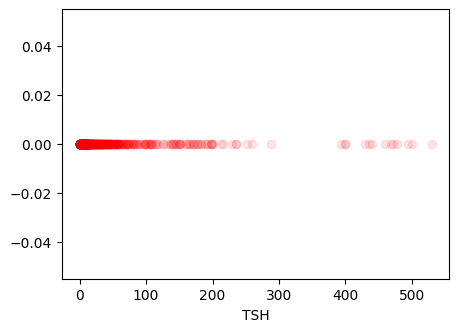

In [104]:
plt.figure(figsize=(5, 3.5))

nbrs = NearestNeighbors(n_neighbors=11, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r_list[idx])
labels_pred = np.where(dist_k >= threshold, 1 ,0)
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0]*0, alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0]*0, alpha=0.1, c="red")

plt.xlabel("TSH")
plt.show()

Logarytm przy zmiennej x (TSH)

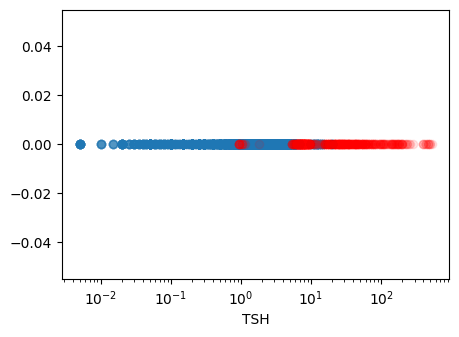

In [105]:
plt.figure(figsize=(5, 3.5))

plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0]*0, alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0]*0, alpha=0.1, c="red")

plt.xscale("log")
plt.xlabel("TSH")
plt.show()

\newpage

## Siatka po k (przy r=0.0887)

In [106]:
metrics_list = []
k_list = []
for k in [11, 21, 51, 101]:
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute').fit(x_train)
    distances, indices = nbrs.kneighbors(x_train)
    dist_k = np.max(distances, axis=1)
    threshold = np.quantile(dist_k, 1 - 0.0887)
    labels_pred = np.where(dist_k >= threshold, 1, 0)
    
    inliers = labels_pred == 0
    outliers = labels_pred == 1
    n_outliers = (outliers == 1).sum()
    n_inliers = (outliers == 0).sum()
    tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
    dist_out = np.sort(dist_k[outliers])[:tmp]
    dist_in = np.sort(dist_k[inliers])[-tmp:]
    metric = dist_in.sum() / dist_out.sum()

    metrics_list.append(metric)
    k_list.append(k-1)

idx = np.argmin(metrics_list)
print(f"Najlepsze k: {k_list[idx]:.3f}, Wskaźnik: {metrics_list[idx]:.3f}\n")

res = confusion_matrix(labels_train, labels_pred)
print(res)
print(f"precision: {res[1, 1] / res[:, 1].sum()}")
print(f"recall: {res[1, 1] / res[1, :].sum()}")
print(f"accuracy: {np.diag(res).sum() / res.sum()}")

Najlepsze k: 100.000, Wskaźnik: 0.743

[[6033   49]
 [  40  552]]
precision: 0.9184692179700499
recall: 0.9324324324324325
accuracy: 0.9866646688642493


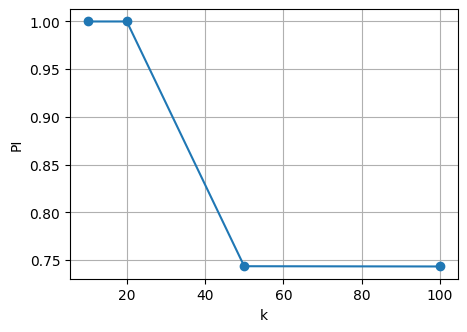

In [107]:
plt.figure(figsize=(5, 3.5))
plt.plot(k_list, metrics_list, "-o")
plt.xlabel("k")
plt.ylabel("PI")
plt.grid()
plt.show()

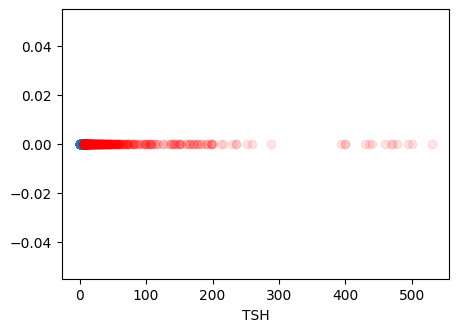

In [108]:
plt.figure(figsize=(5, 3.5))

nbrs = NearestNeighbors(n_neighbors=k_list[idx]+1, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - 0.0887)
labels_pred = np.where(dist_k >= threshold, 1 ,0)
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0]*0, alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0]*0, alpha=0.1, c="red")

plt.xlabel("TSH")
plt.show()

Logarytm przy zmiennej x (TSH)

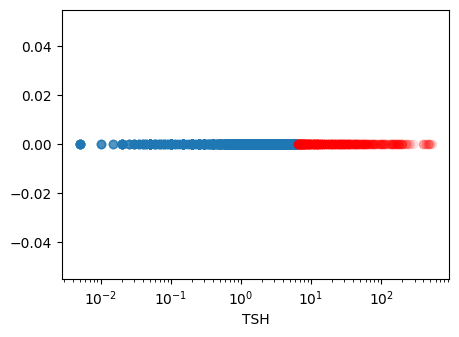

In [109]:
plt.figure(figsize=(5, 3.5))

plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0]*0, alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0]*0, alpha=0.1, c="red")

plt.xscale("log")
plt.xlabel("TSH")
plt.show()

\newpage

## Siatka po k i r

In [110]:
metrics_list = []
k_list = []
r_list = []
for k in [11, 21, 51, 101]:
    for r in np.arange(0.01, 0.11, 0.01):
        r = round(r, 3)
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute').fit(x_train)
        distances, indices = nbrs.kneighbors(x_train)
        dist_k = np.max(distances, axis=1)
        threshold = np.quantile(dist_k, 1 - r)
        labels_pred = np.where(dist_k >= threshold, 1, 0)

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
        dist_out = np.sort(dist_k[outliers])[:tmp]
        dist_in = np.sort(dist_k[inliers])[-tmp:]
        metric = dist_in.sum() / dist_out.sum()

        metrics_list.append(metric)
        k_list.append(k-1)
        r_list.append(r)

idx = np.argmin(metrics_list)
print(f"Najlepsze k: {k_list[idx]:.3f}, r: {r_list[idx]:.3f}, Wskaźnik: {metrics_list[idx]:.3f}\n")

res = confusion_matrix(labels_train, labels_pred)
print(res)
print(f"precision: {res[1, 1] / res[:, 1].sum()}")
print(f"recall: {res[1, 1] / res[1, :].sum()}")
print(f"accuracy: {np.diag(res).sum() / res.sum()}")

Najlepsze k: 10.000, r: 0.080, Wskaźnik: 0.126

[[5989   93]
 [   0  592]]
precision: 0.8642335766423358
recall: 1.0
accuracy: 0.986065328139047


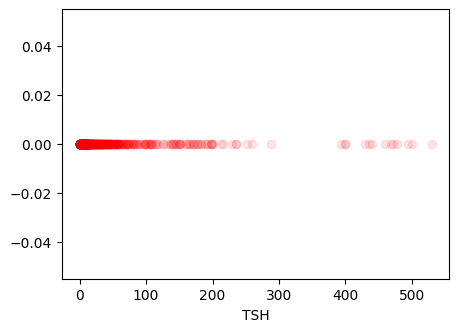

In [111]:
plt.figure(figsize=(5, 3.5))

nbrs = NearestNeighbors(n_neighbors=k_list[idx]+1, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r_list[idx])
labels_pred = np.where(dist_k >= threshold, 1 ,0)
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0]*0, alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0]*0, alpha=0.1, c="red")

plt.xlabel("TSH")
plt.show()

Logarytm przy zmiennej x (TSH)

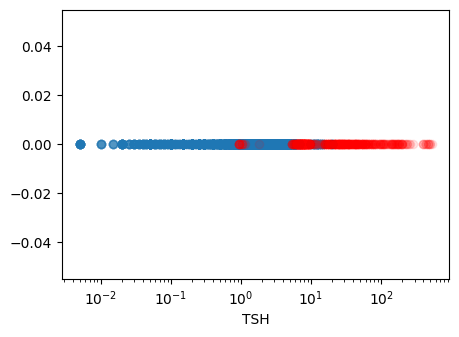

In [112]:
plt.figure(figsize=(5, 3.5))

plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0]*0, alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0]*0, alpha=0.1, c="red")

plt.xscale("log")
plt.xlabel("TSH")
plt.show()